# 1. Import libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import os

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# 2. Load dataset and do some EDA

In [2]:
dataset = pd.read_csv('../data/clean_hcmc_waq.csv', delimiter=",")

In [3]:
dataset.head()

,date_time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,cloud_cover,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,us_aqi,weather_status
0,2022-10-01 00:00:00+00:00,25.511000,94.49476,24.561,31.543438,1.3,44.700000,0.179606,2.902413,209.74480,61.2,42.1,1123.0,50.80,11.50,4.0,73.652490,Light Rain
1,2022-10-01 01:00:00+00:00,26.411001,88.26100,24.311,31.320229,0.6,55.500000,0.403905,9.504272,232.69597,36.9,24.9,906.0,43.05,11.25,14.0,76.471634,Moderate Drizzle
2,2022-10-01 02:00:00+00:00,26.911001,88.03870,24.761,32.211530,0.7,46.200005,0.423807,8.788720,214.99210,28.0,18.5,598.0,31.95,10.90,27.0,77.597520,Moderate Drizzle
3,2022-10-01 03:00:00+00:00,28.011000,85.29904,25.311,33.920822,0.6,100.000000,0.555415,7.072878,194.74360,24.2,15.9,281.0,19.70,10.50,48.0,78.182625,Moderate Drizzle
4,2022-10-01 04:00:00+00:00,29.011000,78.12226,24.811,34.491055,0.4,100.000000,0.875935,7.754637,201.80147,26.0,17.1,213.0,14.25,10.50,67.0,78.430855,Light Drizzle


In [4]:
dataset.columns

Index(['date_time', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation', 'cloud_cover',
       'vapour_pressure_deficit', 'wind_speed_10m', 'wind_direction_10m',
       'pm10', 'pm2_5', 'carbon_monoxide', 'nitrogen_dioxide',
       'sulphur_dioxide', 'ozone', 'us_aqi', 'weather_status'],
      dtype='object')

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date_time                17544 non-null  object 
 1   temperature_2m           17544 non-null  float64
 2   relative_humidity_2m     17544 non-null  float64
 3   dew_point_2m             17544 non-null  float64
 4   apparent_temperature     17544 non-null  float64
 5   precipitation            17544 non-null  float64
 6   cloud_cover              17544 non-null  float64
 7   vapour_pressure_deficit  17544 non-null  float64
 8   wind_speed_10m           17544 non-null  float64
 9   wind_direction_10m       17544 non-null  float64
 10  pm10                     17544 non-null  float64
 11  pm2_5                    17544 non-null  float64
 12  carbon_monoxide          17544 non-null  float64
 13  nitrogen_dioxide         17544 non-null  float64
 14  sulphur_dioxide       

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Light Rain'),
  Text(1, 0, 'Moderate Drizzle'),
  Text(2, 0, 'Light Drizzle'),
  Text(3, 0, 'Moderate Rain'),
  Text(4, 0, 'Overcast'),
  Text(5, 0, 'Heavy Rain'),
  Text(6, 0, 'Dense Drizzle'),
  Text(7, 0, 'Partly Cloudy'),
  Text(8, 0, 'Mainly Clear'),
  Text(9, 0, 'Clear Sky')])

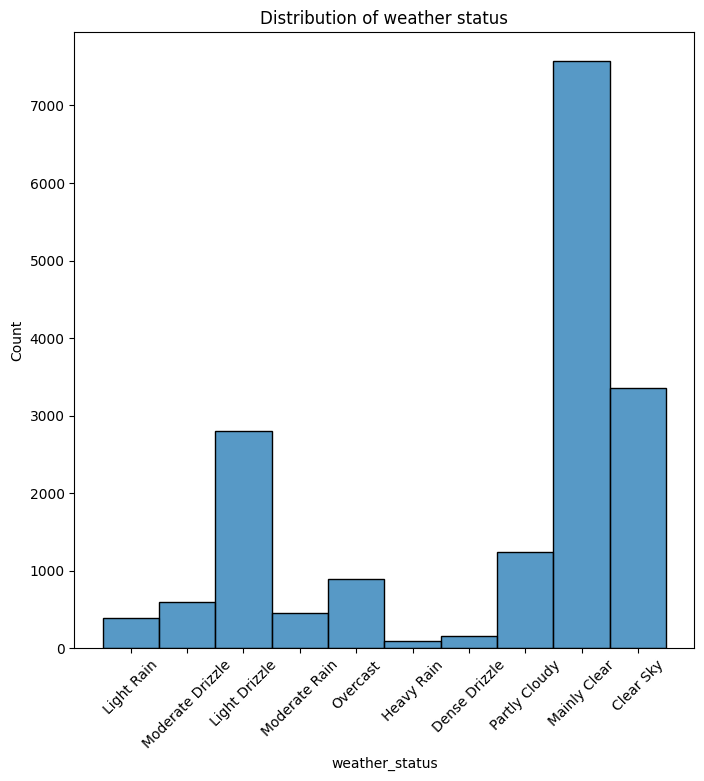

In [56]:
plt.figure(figsize=(8, 8))
sns.histplot(dataset['weather_status'])
plt.title('Distribution of weather status')
plt.xticks(rotation=45)

# 3. Preprocessing dataset

### a. Xử lí label thành dạng numerical

In [7]:
label_encoder = LabelEncoder()
dataset['weather_status_label'] = label_encoder.fit_transform(dataset['weather_status'])

In [8]:
data = dataset.drop(['date_time','weather_status'], axis=1)

<Axes: >

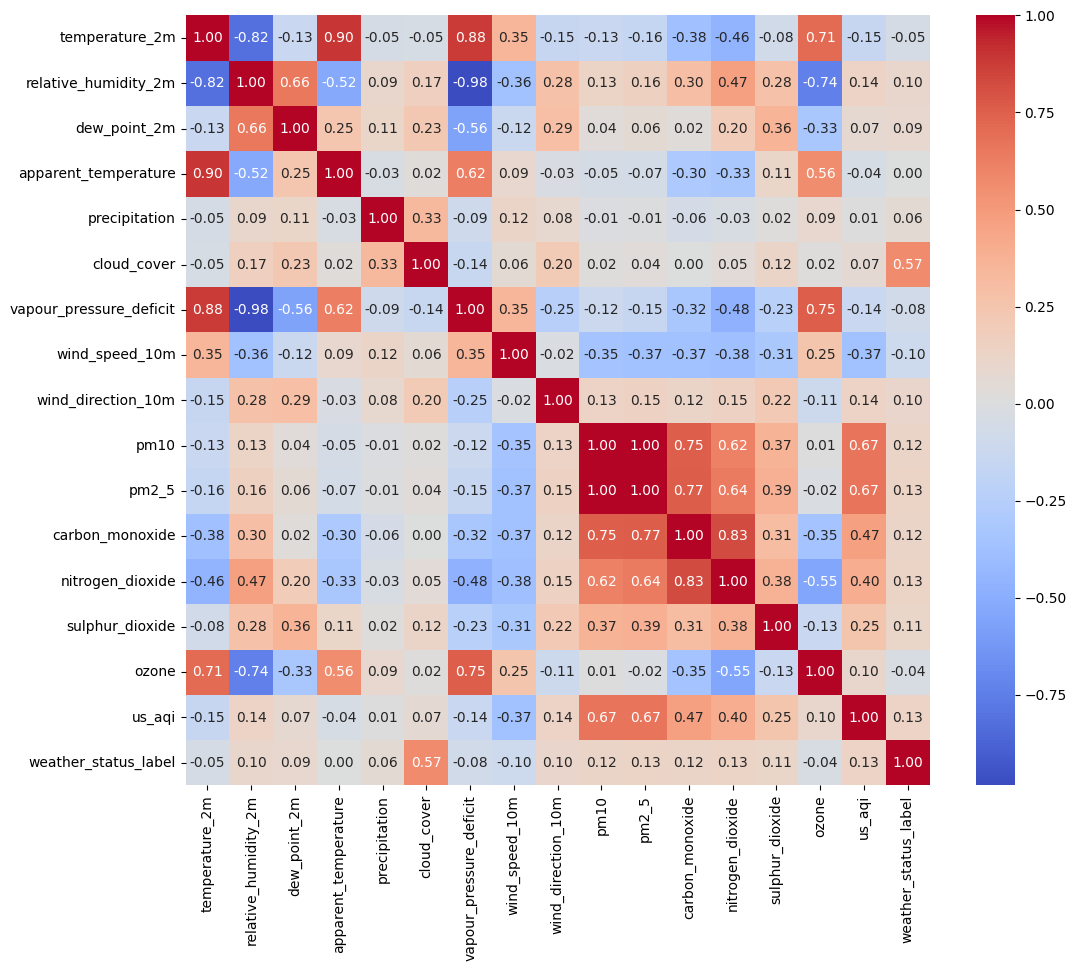

In [9]:
plt.figure(figsize=(12, 10))
correlation = data.corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm')

In [10]:
X = data.drop('weather_status_label', axis=1)
y = data['weather_status_label']

In [11]:
X

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,cloud_cover,vapour_pressure_deficit,wind_speed_10m,wind_direction_10m,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,us_aqi
0,25.511000,94.494760,24.561000,31.543438,1.3,44.700000,0.179606,2.902413,209.74480,61.2,42.1,1123.0,50.80,11.50,4.0,73.652490
1,26.411001,88.261000,24.311000,31.320229,0.6,55.500000,0.403905,9.504272,232.69597,36.9,24.9,906.0,43.05,11.25,14.0,76.471634
2,26.911001,88.038700,24.761000,32.211530,0.7,46.200005,0.423807,8.788720,214.99210,28.0,18.5,598.0,31.95,10.90,27.0,77.597520
3,28.011000,85.299040,25.311000,33.920822,0.6,100.000000,0.555415,7.072878,194.74360,24.2,15.9,281.0,19.70,10.50,48.0,78.182625
4,29.011000,78.122260,24.811000,34.491055,0.4,100.000000,0.875935,7.754637,201.80147,26.0,17.1,213.0,14.25,10.50,67.0,78.430855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,26.011000,96.791306,25.461000,32.294750,0.0,35.400000,0.107814,5.220000,226.39711,33.1,22.9,528.0,43.10,36.30,6.0,85.053185
17540,25.711000,96.784290,25.161001,31.722473,0.0,34.500000,0.106154,5.720490,204.14554,30.4,21.1,474.0,40.50,34.40,4.0,82.641846
17541,25.561000,96.780716,25.011000,31.509857,0.0,33.600000,0.105334,5.474486,189.46225,27.6,19.0,433.0,37.70,33.80,4.0,80.824470
17542,25.311000,97.936900,24.961000,31.394775,0.0,36.900000,0.066511,4.327493,196.92760,27.1,18.6,418.0,34.70,36.10,6.0,79.406030


### b. Chọn ra 10 features tốt nhất

In [12]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=10)  # chọn 10 feature tốt nhất
X_new = selector.fit_transform(X, y)


In [13]:
selected_features = X.columns[selector.get_support()]
selected_features

Index(['precipitation', 'cloud_cover', 'wind_direction_10m', 'pm10', 'pm2_5',
       'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide', 'ozone',
       'us_aqi'],
      dtype='object')

### c. Chia tập dữ liệu thành bộ train và test

In [53]:
# Chia tập dữ liệu thành train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# 4. Train model classification để dự đoán weather_status

## a. Train với các features ban đầu

In [31]:
# Khởi tạo và huấn luyện mô hình RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)


Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       627
           1       0.95      0.67      0.78        30
           2       0.86      0.46      0.60        13
           3       1.00      1.00      1.00       573
           4       0.87      0.95      0.91        78
           5       1.00      1.00      1.00      1527
           6       0.96      0.99      0.97       109
           7       0.93      0.95      0.94       103
           8       1.00      1.00      1.00       172
           9       1.00      1.00      1.00       277

    accuracy                           0.99      3509
   macro avg       0.96      0.90      0.92      3509
weighted avg       0.99      0.99      0.99      3509



## b. Train với 10 features tốt nhất

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Khởi tạo và huấn luyện mô hình RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       627
           1       1.00      0.97      0.98        30
           2       0.90      0.69      0.78        13
           3       1.00      1.00      1.00       573
           4       0.97      1.00      0.99        78
           5       1.00      1.00      1.00      1527
           6       1.00      0.99      1.00       109
           7       0.96      0.97      0.97       103
           8       1.00      0.99      1.00       172
           9       1.00      1.00      1.00       277

    accuracy                           1.00      3509
   macro avg       0.98      0.96      0.97      3509
weighted avg       1.00      1.00      1.00      3509



## c. Vì dữ liệu bị imbalanced giữa các classes, dùng SMOTE để cân bằng samples để mô hình dự đoán tốt trên mọi classes

In [33]:


# Chia dữ liệu ban đầu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Áp dụng SMOTE để cân bằng dữ liệu trên tập train
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Kiểm tra lại phân phối của các lớp sau khi cân bằng
print("Class distribution after SMOTE:")
print(y_train_resampled.value_counts())
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Class distribution after SMOTE:
weather_status_label
5    6040
9    6040
0    6040
8    6040
3    6040
7    6040
6    6040
4    6040
2    6040
1    6040
Name: count, dtype: int64
Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       627
           1       1.00      1.00      1.00        30
           2       0.93      1.00      0.96        13
           3       1.00      1.00      1.00       573
           4       1.00      1.00      1.00        78
           5       1.00      1.00      1.00      1527
           6       1.00      0.99      1.00       109
           7       1.00      0.98      0.99       103
           8       1.00      1.00      1.00       172
           9       1.00      1.00      1.00       277

    accuracy                           1.00      3509
   macro avg       0.99      1.00      0.99      3509
weighted avg       1.00      1.00      1.00      3509



## d. Hyper parameter Tuning

### - GridSearchCV for small number of combinations

In [38]:
param_grid = {'n_estimators': [100,150],
              'max_depth': [5, 10],
              'min_samples_split': [10, 50]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=10, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)
print("Best parameters: {}".format(grid_search.best_params_))
y_predict = grid_search.predict(X_test)
print(classification_report(y_test, y_predict))

Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       627
           1       1.00      1.00      1.00        30
           2       0.93      1.00      0.96        13
           3       1.00      1.00      1.00       573
           4       1.00      1.00      1.00        78
           5       1.00      1.00      1.00      1527
           6       1.00      0.99      1.00       109
           7       1.00      0.99      1.00       103
           8       1.00      1.00      1.00       172
           9       1.00      1.00      1.00       277

    accuracy                           1.00      3509
   macro avg       0.99      1.00      1.00      3509
weighted avg       1.00      1.00      1.00      3509



# 5. Lưu model thành file pkl


In [45]:
# Lưu mô hình vào file
model_folder = 'model'
os.makedirs(model_folder, exist_ok=True)
model_path = os.path.join(model_folder, 'classification.pkl')
joblib.dump(grid_search, model_path)

print(f"Model saved to {model_path}")

Model saved to model/classification.pkl


# 6. Pridicting Pipeline

In [50]:
loaded_model = joblib.load('/content/model/classification.pkl')

# Cho data mẫu
input_data = {
    'precipitation': [0.0],
    'cloud_cover': [10.0],
    'wind_direction_10m': [180.0],
    'pm10': [20.0],
    'pm2_5': [10.0],
    'carbon_monoxide': [0.2],
    'nitrogen_dioxide': [10.0],
    'sulphur_dioxide': [0.005],
    'ozone': [30.0],
    'us_aqi': [50.0]
}
input_df = pd.DataFrame(input_data)

predictions = loaded_model.predict(input_df)
print("Dự đoán weather status:", label_encoder.inverse_transform(predictions))

Dự đoán weather status: ['Clear Sky']
